In [28]:
from __future__ import division
import csv
import numpy as np
import matplotlib.pylab as plt
from scipy.signal import resample
import mne
import pandas as pd
import seaborn as sns
from scipy.signal import hilbert
#from utils import circular_histogram
#import pycircstat
import os
from datetime import datetime
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Stanislas Chambon <stan.chambon@gmail.com>
#          Joan Massich <mailsik@gmail.com>
#
# License: BSD Style.

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn import preprocessing

# Helpful reading: https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

In [58]:
file_dir='D:\IM 680'

In [59]:
patient_id=1351;duration=30;

In [60]:
patient_list=[1351,2510,2939,4301,5852,5995,7257,7838,7844,8898]

In [61]:
patient_id = patient_list[0]

In [62]:
data = pd.read_csv( os.path.join(file_dir, str(patient_id)+'.csv')) 

In [63]:
data=data[data['Sleep stage code']!=99]

data.rename(columns={'Unnamed: 0':'SUBJID'},inplace=True)

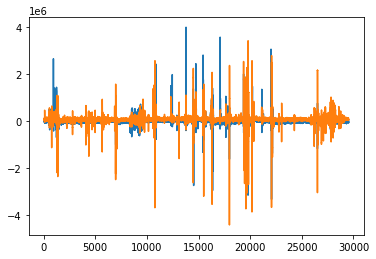

In [64]:
plt.plot(data['time'].values,data['EEG 1E1'].values)
plt.plot(data['time'].values,data['EEG 1E2'].values)

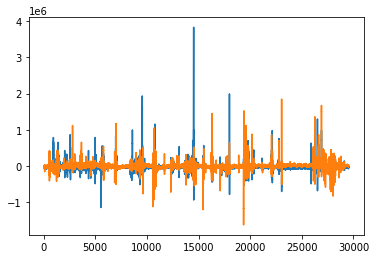

In [65]:
plt.plot(data['time'].values,data['EEG 2E1'].values)
plt.plot(data['time'].values,data['EEG 2E2'].values)

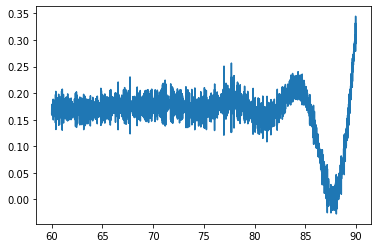

In [66]:
plt.plot(data['time'].values[:3000],data['GRY 1EZ'].values[:3000])

In [67]:
data

,SUBJID,sleep stage,time,GRY 1EX,GRY 1EY,GRY 1EZ,GRY 2EX,GRY 2EY,GRY 2EZ,ACC 1EX,ACC 1EY,ACC 1EZ,ACC 2EX,ACC 2EY,ACC 2EZ,EEG 1E1,EEG 1E2,EEG 2E1,EEG 2E2,Sleep stage code
6000,6000,W,60.00,-0.196437,-0.325243,0.161619,-0.196437,-0.325243,0.161619,-0.282754,-0.748382,-0.092388,-0.336052,-0.720050,-0.172444,7656.030632,62913.779879,-12262.937267,-34169.897271,0
6001,6001,W,60.01,-0.214679,-0.257129,0.176498,-0.214679,-0.257129,0.176498,-0.281402,-0.749309,-0.092396,-0.336296,-0.719576,-0.171665,-1914.617383,73118.888835,-25752.872946,-35973.472605,0
6002,6002,W,60.02,-0.162107,-0.305785,0.166042,-0.162107,-0.305785,0.166042,-0.282454,-0.748283,-0.091328,-0.335286,-0.720003,-0.171601,3500.989091,63987.310747,-14415.555900,-40072.735216,0
6003,6003,W,60.03,-0.226300,-0.272984,0.166292,-0.226300,-0.272984,0.166292,-0.281891,-0.749416,-0.093305,-0.337054,-0.719583,-0.172407,1362.868495,72940.346808,-18256.591384,-35595.864697,0
6004,6004,W,60.04,-0.169552,-0.298739,0.177852,-0.169552,-0.298739,0.177852,-0.282155,-0.748242,-0.090911,-0.334968,-0.719964,-0.171201,2968.238436,63731.269227,-22367.933287,-37177.439909,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2951995,2951995,N2,29519.95,-0.203470,-0.381837,0.195216,-0.203470,-0.381837,0.195216,-0.210622,0.726173,-0.370416,-0.095876,0.701910,-0.395967,-44678.947526,79610.564485,-26320.844163,12264.109981,2
2951996,2951996,N2,29519.96,-0.205994,-0.369446,0.118806,-0.205994,-0.369446,0.118806,-0.210388,0.727356,-0.370846,-0.096368,0.701263,-0.395859,-50100.116438,89722.999012,-34032.905484,10178.708091,2
2951997,2951997,N2,29519.97,-0.195864,-0.368450,0.199612,-0.195864,-0.368450,0.199612,-0.210809,0.726429,-0.370287,-0.096104,0.701580,-0.396447,-49373.916272,77208.003968,-26262.310204,15441.349794,2
2951998,2951998,N2,29519.98,-0.217731,-0.376059,0.136401,-0.217731,-0.376059,0.136401,-0.210240,0.726864,-0.370662,-0.095915,0.701592,-0.395352,-44512.100146,87823.334779,-31534.769275,8962.787726,2


In [34]:
def data_reform(patient_id,duration): 
    data = pd.read_csv( os.path.join(file_dir, str(patient_id)+'.csv')) 

    data=data[data['Sleep stage code']!=99]

    data.rename(columns={'Unnamed: 0':'SUBJID'},inplace=True)

    data['SUBJID']=patient_id

    data['Sleep stage code'].values

    sample1=data.iloc[:,3:-1]

    x = sample1.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler(feature_range= (-1,1))
    x_scaled = min_max_scaler.fit_transform(x)
    #df = pd.DataFrame(x_scaled)

    #int(len(sample1)/duration)

    reformed_xdata=[]
    reformed_ydata=[]
    duration=duration*100;
    for i in range(int(len(sample1)/duration)):
        reformed_xdata.append(x_scaled[duration*i:duration*(i+1)])
        reformed_ydata.append(data['Sleep stage code'].values[i*duration])
    
    return reformed_xdata,reformed_ydata

In [60]:
duration = 30 

In [76]:
reformed_xdata=[]
reformed_ydata=[]
patient_length=[]
for patient_id in patient_list:
    duration = 30 
    xdata,ydata = data_reform(patient_id,duration)
    reformed_xdata+=xdata
    reformed_ydata+=ydata
    patient_length.append(len(ydata))

In [77]:
len(reformed_xdata)

9228

In [79]:
np.save(r'C:\Users\ASUS\Documents\school\IM680\SleepySignals_X.npy',reformed_xdata)

In [80]:
np.save(r'C:\Users\ASUS\Documents\school\IM680\SleepySignals_y.npy',reformed_ydata)

In [78]:
patient_length

[982, 923, 886, 919, 861, 1057, 941, 902, 888, 869]